# How can the model classify BC order with only the word embedding?

In the slides from Nov 11, we saw that the tagging model has the ability to classify real from fake with very high accuracy (97%) using only the word vectors. 

One hypothesis is that the word vector contains information about the tones, so that adding explicit tonal features does not further improve the accuracy. However, from the embedding classification experiment we saw that this wasn't the case. 

Another possibility is that the embedding learns that certain words are good "B" words and others are good "C" words. However, because the train/test split is designed so that the same elaborate expression occurs in either train or test, not both. This means that if the model learns certain words are good "B" words and good "C" words, it must have learned it from other occurrences of these words out side of elaborate expressions, for example as a word "BC". To verify this, we first want to check, how often does the bigram "BC" occur, where B and C are the coordinate compounds in the elaborate expression ABAC.

In [18]:
import numpy as np
import pandas as pd
import os
import torch
from collections import Counter

## For the EEs (ABAC) in the val/test set, how often does BC appear in the training data?
- as a bigram BC
- as a bigram CB
- as a 4gram XBXC, where X are the same
- as a 4gram XCXB, where X are the same

In [2]:
data = torch.load("../data/hmong/data.pth")
split = torch.load("../data/hmong/split_grouped_1.pth")

In [3]:
data.keys()

dict_keys(['sentences', 'tags', 'l2i', 'i2l', 'w2i', 'i2w', 'c2i', 'i2c', 'wi2ci'])

In [4]:
split.keys()

dict_keys(['train', 'val', 'test', 'train_elabs', 'valtest_elabs', 'train_elabs_swap', 'train_elabs_keep', 'valtest_elabs_swap', 'valtest_elabs_keep'])

In [5]:
split['valtest_elabs']

{('cai', 'pab', 'cai', 'pawg'),
 ('cai', 'xeem', 'cai', 'neeg'),
 ('cam', 'ub', 'cam', 'no'),
 ('ceg', 'neej', 'ceg', 'tsav'),
 ('ceg', 'siab', 'ceg', 'qes'),
 ('cis', 'fij', 'cis', 'tom'),
 ('coj', 'dab', 'coj', 'qhua'),
 ('cov', 'niam', 'cov', 'txiv'),
 ('cov', 'nom', 'cov', 'tswv'),
 ('cov', 'poj', 'cov', 'yawm'),
 ('dab', 'ntuj', 'dab', 'teb'),
 ('dab', 'tooj', 'dab', 'hlau'),
 ('dhau', 'caij', 'dhau', 'nyoog'),
 ('fuab', 'noj', 'fuab', 'haus'),
 ('hais', 'dog', 'hais', 'dig'),
 ('hais', 'mus', 'hais', 'los'),
 ('hais', 'ruaj', 'hais', 'khov'),
 ('hau', 'yeeb', 'hau', 'tshuaj'),
 ('hauv', 'paus', 'hauv', 'ntsis'),
 ('hauv', 'zej', 'hauv', 'zos'),
 ('hla', 'zeb', 'hla', 'tsua'),
 ('hlas', 'roob', 'hlas', 'hav'),
 ('hlawv', 'xyab', 'hlawv', 'ntawv'),
 ('hlev', 'liab', 'hlev', 'ntsuab'),
 ('hneev', 'tes', 'hneev', 'taw'),
 ('huv', 'zej', 'huv', 'zog'),
 ('ib', 'tsam', 'ib', 'pliag'),
 ('ib', 'txhiab', 'ib', 'txhis'),
 ('kaus', 'tauj', 'kaus', 'nqeeb'),
 ('keb', 'ub', 'keb', 'no'),
 ('

In [6]:
BC_indices = set([])
CB_indices = set([])
for (A, B, A, C) in split['valtest_elabs']:
    BC_indices.add((data['w2i'][B], data['w2i'][C]))
    CB_indices.add((data['w2i'][C], data['w2i'][B]))


In [7]:
train_sentences = [data['sentences'][t] for t in split['train']]

In [8]:
from collections import defaultdict
# note: the keys for all of below are in BC order.
BC_count = defaultdict(int)
CB_count = defaultdict(int)
XBXC_count = defaultdict(int)
XCXB_count = defaultdict(int)

for sent in train_sentences:
    for i in range(1, len(sent)):
        if (sent[i-1], sent[i]) in BC_indices:
            BC_count[(sent[i-1], sent[i])] += 1
        elif (sent[i-1], sent[i]) in CB_indices:
            CB_count[(sent[i], sent[i-1])] += 1
        elif i < len(sent) - 2 and sent[i-1] == sent[i+1]:
            if (sent[i], sent[i+2]) in BC_indices:
                XBXC_count[(sent[i], sent[i+2])] += 1
            if (sent[i], sent[i+2]) in CB_indices:
                XCXB_count[(sent[i+2], sent[i])] += 1

In [9]:
XBXC_count

defaultdict(int,
            {(216, 12): 2621,
             (532, 372): 89,
             (66, 229): 996,
             (68, 474): 533,
             (579, 394): 90,
             (210, 132): 758,
             (173, 2557): 40,
             (99, 74): 955,
             (198, 373): 163,
             (415, 162): 467,
             (186, 161): 909,
             (293, 666): 204,
             (620, 699): 119,
             (191, 190): 103,
             (95, 284): 1388,
             (959, 159): 77,
             (100, 258): 217,
             (155, 192): 440,
             (118, 537): 332,
             (363, 232): 48,
             (137, 116): 80,
             (80, 47): 53,
             (139, 330): 129,
             (43, 181): 196,
             (825, 349): 70,
             (1024, 797): 232,
             (662, 132): 92,
             (151, 66): 213,
             (606, 631): 26,
             (100, 2283): 60,
             (216, 326): 191,
             (313, 307): 164,
             (429, 162): 15,
          

In [10]:
columns = ["B_word", "C_word", "BC_occurrence", "CB_occurrence", "XBXC_occurrence", "XCXB_occurrence"]
rows = list(BC_indices)
df = pd.DataFrame(np.zeros((len(rows), len(columns))), 
                           columns=columns, index=rows, dtype=int)

In [11]:
df['B_word'] = list(map(data['i2w'].__getitem__, list(zip(*rows))[0]))
df['C_word'] = list(map(data['i2w'].__getitem__, list(zip(*rows))[1]))
df['BC_occurrence'] = [BC_count[bc] for bc in rows]
df['CB_occurrence'] = [CB_count[bc] for bc in rows]
df['XBXC_occurrence'] = [XBXC_count[bc] for bc in rows]
df['XCXB_occurrence'] = [XCXB_count[bc] for bc in rows]

In [71]:
df.to_csv("test_BC_in_train_corpus.csv")

## Visualize the density of BC, CB, XBXC, XCXB as box plots

Text(0.5, 1.0, 'Test BC in training corpus')

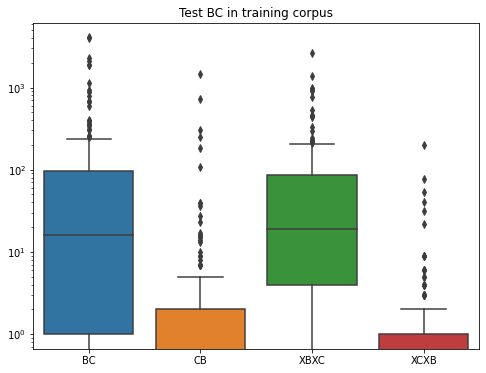

In [12]:
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

df = pd.read_csv("test_BC_in_train_corpus.csv")

N = len(df)
x = ['BC']*N + ['CB']*N + ['XBXC']*N + ['XCXB']*N
y = df['BC_occurrence'].tolist() + \
    df['CB_occurrence'].tolist() + \
    df['XBXC_occurrence'].tolist() + \
    df['XCXB_occurrence'].tolist() 

plt.figure(figsize=[8, 6])
ax = sns.boxplot(x=x, y=y)
ax.set_yscale("log")
ax.set_title("Test BC in training corpus")

In [14]:
split['train_elabs']

{('kev', 'tshaib', 'kev', 'nqhis'),
 ('yuav', 'ciaj', 'yuav', 'tuag'),
 ('sib', 'hlub', 'sib', 'nco'),
 ('nyiag', 'ntaub', 'nyiag', 'ntawv'),
 ('lub', 'dag', 'lub', 'zog'),
 ('tej', 'mab', 'tej', 'suav'),
 ('uas', 'neeb', 'uas', 'yaig'),
 ('ua', 'teb', 'ua', 'chaw'),
 ('ntsiab', 'ub', 'ntsiab', 'no'),
 ('zov', 'ruaj', 'zov', 'khov'),
 ('muaj', 'kiab', 'muaj', 'khw'),
 ('koom', 'zej', 'koom', 'zog'),
 ('sib', 'txheeb', 'sib', 'ze'),
 ('hla', 'mus', 'hla', 'los'),
 ('nyeem', 'ntaub', 'nyeem', 'ntawv'),
 ('lus', 'zoo', 'lus', 'phem'),
 ('nrog', 'vaj', 'nrog', 'tsev'),
 ('tug', 'yeej', 'tug', 'swb'),
 ('lawv', 'vaj', 'lawv', 'tsev'),
 ('du', 'mus', 'du', 'los'),
 ('ua', 'nyiaj', 'ua', 'txiaj'),
 ('suab', 'ntaj', 'suab', 'phom'),
 ('dej', 'siab', 'dej', 'ntsws'),
 ('qav', 'nom', 'qav', 'tswv'),
 ('tsis', 'yog', 'tsis', 'raug'),
 ('txia', 'mus', 'txia', 'los'),
 ('dheev', 'ub', 'dheev', 'no'),
 ('yog', 'nom', 'yog', 'tswv'),
 ('kuaj', 'mus', 'kuaj', 'los'),
 ('hom', 'roob', 'hom', 'hav'),
 (

In [15]:
split['valtest_elabs']

{('cai', 'pab', 'cai', 'pawg'),
 ('cai', 'xeem', 'cai', 'neeg'),
 ('cam', 'ub', 'cam', 'no'),
 ('ceg', 'neej', 'ceg', 'tsav'),
 ('ceg', 'siab', 'ceg', 'qes'),
 ('cis', 'fij', 'cis', 'tom'),
 ('coj', 'dab', 'coj', 'qhua'),
 ('cov', 'niam', 'cov', 'txiv'),
 ('cov', 'nom', 'cov', 'tswv'),
 ('cov', 'poj', 'cov', 'yawm'),
 ('dab', 'ntuj', 'dab', 'teb'),
 ('dab', 'tooj', 'dab', 'hlau'),
 ('dhau', 'caij', 'dhau', 'nyoog'),
 ('fuab', 'noj', 'fuab', 'haus'),
 ('hais', 'dog', 'hais', 'dig'),
 ('hais', 'mus', 'hais', 'los'),
 ('hais', 'ruaj', 'hais', 'khov'),
 ('hau', 'yeeb', 'hau', 'tshuaj'),
 ('hauv', 'paus', 'hauv', 'ntsis'),
 ('hauv', 'zej', 'hauv', 'zos'),
 ('hla', 'zeb', 'hla', 'tsua'),
 ('hlas', 'roob', 'hlas', 'hav'),
 ('hlawv', 'xyab', 'hlawv', 'ntawv'),
 ('hlev', 'liab', 'hlev', 'ntsuab'),
 ('hneev', 'tes', 'hneev', 'taw'),
 ('huv', 'zej', 'huv', 'zog'),
 ('ib', 'tsam', 'ib', 'pliag'),
 ('ib', 'txhiab', 'ib', 'txhis'),
 ('kaus', 'tauj', 'kaus', 'nqeeb'),
 ('keb', 'ub', 'keb', 'no'),
 ('

In [25]:
train_BC_cntr = Counter((b, c) for (a, b, a, c) in split['train_elabs'])
train_BC_cntr

Counter({('tshaib', 'nqhis'): 3,
         ('ciaj', 'tuag'): 20,
         ('hlub', 'nco'): 1,
         ('ntaub', 'ntawv'): 20,
         ('dag', 'zog'): 9,
         ('mab', 'suav'): 15,
         ('neeb', 'yaig'): 7,
         ('teb', 'chaw'): 68,
         ('ub', 'no'): 100,
         ('ruaj', 'khov'): 3,
         ('kiab', 'khw'): 1,
         ('zej', 'zog'): 12,
         ('txheeb', 'ze'): 14,
         ('mus', 'los'): 51,
         ('zoo', 'phem'): 10,
         ('vaj', 'tsev'): 49,
         ('yeej', 'swb'): 8,
         ('nyiaj', 'txiaj'): 16,
         ('ntaj', 'phom'): 3,
         ('siab', 'ntsws'): 22,
         ('nom', 'tswv'): 57,
         ('yog', 'raug'): 3,
         ('roob', 'hav'): 17,
         ('sab', 'plawv'): 2,
         ('ntuj', 'teb'): 25,
         ('siab', 'plawv'): 7,
         ('hlwb', 'ceg'): 1,
         ('vaaj', 'tsev'): 16,
         ('dlog', 'dlig'): 2,
         ('ntsej', 'muag'): 26,
         ('niam', 'txiv'): 49,
         ('pab', 'pawg'): 28,
         ('khib', 'chim'): 2,
   

In [28]:
valtest_BC_cntr = Counter((b, c) for (a, b, a, c) in split['valtest_elabs'])
for val_bc, val_bc_count in valtest_BC_cntr.most_common():
    print(val_bc, "Valtest count:", val_bc_count, "Train count:", train_BC_cntr.get(val_bc, 0))

('ub', 'no') Valtest count: 11 Train count: 100
('noj', 'haus') Valtest count: 8 Train count: 67
('kwv', 'tij') Valtest count: 8 Train count: 47
('niam', 'txiv') Valtest count: 6 Train count: 49
('nom', 'tswv') Valtest count: 5 Train count: 57
('zej', 'zos') Valtest count: 5 Train count: 26
('teb', 'chaw') Valtest count: 4 Train count: 68
('nyiaj', 'txiaj') Valtest count: 4 Train count: 16
('tes', 'taw') Valtest count: 4 Train count: 38
('tub', 'ntxhais') Valtest count: 4 Train count: 13
('roj', 'ntshav') Valtest count: 3 Train count: 15
('mus', 'los') Valtest count: 3 Train count: 51
('ntuj', 'teb') Valtest count: 3 Train count: 25
('vaj', 'tsev') Valtest count: 3 Train count: 49
('riam', 'phom') Valtest count: 3 Train count: 20
('roob', 'hav') Valtest count: 2 Train count: 17
('dag', 'zog') Valtest count: 2 Train count: 9
('poj', 'yawm') Valtest count: 2 Train count: 10
('nuj', 'nqi') Valtest count: 2 Train count: 10
('paub', 'pom') Valtest count: 2 Train count: 9
('phem', 'zoo') Val

This is a problem. We should probably create a split so that train BC and valtest BC are nonoverlapping.

## Partition CC into train and valtest

Previously: 
- Naive Split
- partitioning EE into train and valtest
    - this leads to some ABAC in the valtest test and XBXC in the training set. 

Now:
- partitioning CC into train and valtest
    - Hopefully this removes some word indices memorization


In [84]:
DATA_FOLDER = '../data/hmong/sch_corpus2_elab'
UNTAGGED_DATA_FOLDER = '../data/hmong/sch_corpus2_conll'
NUM_FILES = 9670
FNAME = 'sch-{:05d}.conll'

In [85]:
def find_BC_in_one_file(path, separate_comma=True):
    with open(path) as f:
        lines = f.read().split('\n')
#     print(lines)
    elabs = Counter()
    sep = 0  # if this reaches 2, it's a new sentence
    cur_elab = []
    for line in lines:
        if len(line) > 0 and line[-1] != 'O':
            if line[-1] == 'B':
                cur_elab = [line.split('\t')[0]]
            elif line[-1] == 'I':
                cur_elab.append(line.split('\t')[0])
            if len(cur_elab) == 4:
#                 print(cur_elab)
                # B and C
                elabs[(cur_elab[1], cur_elab[3])] += 1
                
    return elabs

all_BCs = Counter()
for i in range(1, NUM_FILES+1):
    elabs_in_this_file = find_BC_in_one_file(os.path.join(DATA_FOLDER, FNAME.format(i)), separate_comma=True)
    all_BCs.update(elabs_in_this_file)

In [86]:
all_BCs.most_common(20)

[(('ub', 'no'), 2648),
 (('noj', 'haus'), 1642),
 (('teb', 'chaw'), 976),
 (('niam', 'txiv'), 959),
 (('nom', 'tswv'), 943),
 (('vaj', 'tsev'), 736),
 (('pab', 'pawg'), 550),
 (('txawj', 'ntse'), 539),
 (('leej', 'tus'), 477),
 (('ntsej', 'muag'), 468),
 (('kwv', 'tij'), 407),
 (('noj', 'ua'), 358),
 (('mus', 'los'), 346),
 (('neej', 'tsav'), 306),
 (('zej', 'zos'), 290),
 (('hnub', 'hmo'), 283),
 (('koob', 'npe'), 277),
 (('tub', 'nyuam'), 277),
 (('nkauj', 'nraug'), 230),
 (('dog', 'dig'), 226)]

In [87]:
import random

sd = 18
random.seed(sd)

num_datasets = 3
# these sets have EEs as elements
train_sets, valtest_sets = [set([]) for _ in range(num_datasets)], [set([]) for _ in range(num_datasets)]
train_count, valtest_count = [0]*num_datasets, [0]*num_datasets

for i in range(num_datasets):
    for bc, count in all_BCs.items():
        if random.random() > 0.9139:
            valtest_sets[i].add(bc)
            valtest_count[i] += count
        else:
            train_sets[i].add(bc)
            train_count[i] += count
print('seed', sd, 'valtest:', valtest_count, 'train:', train_count)
#     print(valtest_count)
#     print(train_count)

seed 18 valtest: [1533, 2572, 5962] train: [23574, 22535, 19145]


Three fairly different splits to test the model's ability. Split 3 might be the hardest because it has the most number of unseen BCs in the valtest set, although this doesn't take into account the occurrence of "BC" as a bigram in the corpus.

In [88]:
data = torch.load("../data/hmong/data.pth")
SENTENCES, TAGS = data['sentences'], data['tags']
i2w = data['i2w']

In [90]:
sd = 18
random.seed(sd)
def find_EEs(sentence, tag):
    EEs = []
    assert len(sentence) == len(tag)
    for token, a_tag in zip(sentence, tag):
        if a_tag in ('B', 3):
            EEs.append([token])
        elif a_tag in ('I', 2):
            EEs[-1].append(token)       
    return EEs


# these sets have sentence id as elements
train_splits, val_splits, test_splits = [set([]) for _ in range(num_datasets)], [set([]) for _ in range(num_datasets)], [set([]) for _ in range(num_datasets)]


contaminate_train_set = False
if contaminate_train_set:
    reduction_func = all
else:
    reduction_func = any

for n in range(num_datasets):
    val_p, val_n, test_p, test_n, train_p, train_n = 0, 0, 0, 0, 0, 0
    for identifier, s in SENTENCES.items():
        if identifier in TAGS:
            # this is a positive sentence
            t = TAGS[identifier]
            EEs_in_this_sentence = find_EEs(s, t)
            # if a sentence contains one EE belonging to train and one EE belonging to valtest,
            # we choose to put it in the training set (contaminate the training set) 
            # i.e. put it in valtest only if all EEs in the sentence belong to valtest
            # training set much larger, so impact of contamination is reduced
            if reduction_func((len(ee) == 4 and (i2w[ee[1]], i2w[ee[3]]) in valtest_sets[n]) for ee in EEs_in_this_sentence):
                if random.random() >= 0.5:
                    val_p += 1
                    val_splits[n].add(identifier)
                else:
                    test_p += 1
                    test_splits[n].add(identifier)
            else:
                train_p += 1
                train_splits[n].add(identifier)
        else:
            # this is a negative sentence
            if random.random() > 0.9124:
                if random.random() >= 0.5:
                    val_n += 1
                    val_splits[n].add(identifier)
                else:
                    test_n += 1
                    test_splits[n].add(identifier)
            else:
                train_n += 1
                train_splits[n].add(identifier)
    print(n)                
    print('train_p', train_p)
    print('train_n', train_n)
    print('val_p', val_p)
    print('val_n', val_n)
    print('test_p', test_p)
    print('test_n', test_n)
    print()


0
train_p 21758
train_n 687275
val_p 757
val_n 33069
test_p 719
test_n 32951

1
train_p 20741
train_n 687741
val_p 1222
val_n 32509
test_p 1271
test_n 33045

2
train_p 17518
train_n 686979
val_p 2819
val_n 33177
test_p 2897
test_n 33139



In [91]:
for n in range(num_datasets):
    # Partition the grouped splits into 50% swap and 50% keep
    train_elabs = list(train_sets[n])
    valtest_elabs = list(valtest_sets[n])
    random.shuffle(train_elabs)
    random.shuffle(valtest_elabs)

    train_elabs_swap = train_elabs[:len(train_elabs)//2]
    train_elabs_keep = train_elabs[len(train_elabs)//2:]
    valtest_elabs_swap = valtest_elabs[:len(valtest_elabs)//2]
    valtest_elabs_keep = valtest_elabs[len(valtest_elabs)//2:]
    
    split = {'train': train_splits[n], 'val': val_splits[n], 'test': test_splits[n],
            'train_elabs': train_sets[n], 'valtest_elabs': valtest_sets[n],
            'train_elabs_swap': train_elabs_swap,
            'train_elabs_keep': train_elabs_keep,
            'valtest_elabs_swap': valtest_elabs_swap,
            'valtest_elabs_keep': valtest_elabs_keep,
            }
    torch.save(split, f"../data/hmong/split_partitionCC_contamVal_{n+1}.pth")

## What does the box plot look like now?

In [92]:
from collections import defaultdict
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


In [93]:
BC_indices = set([])
CB_indices = set([])
for (B, C) in split['valtest_elabs']:
    BC_indices.add((data['w2i'][B], data['w2i'][C]))
    CB_indices.add((data['w2i'][C], data['w2i'][B]))

train_sentences = [data['sentences'][t] for t in split['train']]

# note: the keys for all of below are in BC order.
BC_count = defaultdict(int)
CB_count = defaultdict(int)
XBXC_count = defaultdict(int)
XCXB_count = defaultdict(int)

for sent in train_sentences:
    for i in range(1, len(sent)):
        if (sent[i-1], sent[i]) in BC_indices:
            BC_count[(sent[i-1], sent[i])] += 1
        elif (sent[i-1], sent[i]) in CB_indices:
            CB_count[(sent[i], sent[i-1])] += 1
        elif i < len(sent) - 2 and sent[i-1] == sent[i+1]:
            if (sent[i], sent[i+2]) in BC_indices:
                XBXC_count[(sent[i], sent[i+2])] += 1
            if (sent[i], sent[i+2]) in CB_indices:
                XCXB_count[(sent[i+2], sent[i])] += 1
                
columns = ["B_word", "C_word", "BC_occurrence", "CB_occurrence", "XBXC_occurrence", "XCXB_occurrence"]
rows = list(BC_indices)
df = pd.DataFrame(np.zeros((len(rows), len(columns))), 
                           columns=columns, index=rows, dtype=int)
df['B_word'] = list(map(data['i2w'].__getitem__, list(zip(*rows))[0]))
df['C_word'] = list(map(data['i2w'].__getitem__, list(zip(*rows))[1]))
df['BC_occurrence'] = [BC_count[bc] for bc in rows]
df['CB_occurrence'] = [CB_count[bc] for bc in rows]
df['XBXC_occurrence'] = [XBXC_count[bc] for bc in rows]
df['XCXB_occurrence'] = [XCXB_count[bc] for bc in rows]

Text(0.5, 1.0, 'Test BC in training corpus, partitioned by CC')

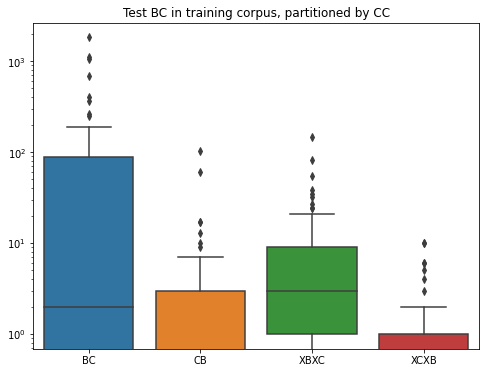

In [94]:
N = len(df)
x = ['BC']*N + ['CB']*N + ['XBXC']*N + ['XCXB']*N
y = df['BC_occurrence'].tolist() + \
    df['CB_occurrence'].tolist() + \
    df['XBXC_occurrence'].tolist() + \
    df['XCXB_occurrence'].tolist() 

plt.figure(figsize=[8, 6])
ax = sns.boxplot(x=x, y=y)
ax.set_yscale("log")
ax.set_title("Test BC in training corpus, partitioned by CC")